In [1]:
from qiskit import QuantumCircuit
from math import pi
import numpy as np
from scipy.linalg import sqrtm, fractional_matrix_power
from scipy.linalg import fractional_matrix_power
from qiskit.quantum_info import Operator
from qiskit.circuit.library import UnitaryGate
from qiskit.quantum_info import random_unitary

The algorithm assumes access to a **single–controlled $U$** gate. I construct this using the standard **AXBXC** decomposition described in *Nielsen & Chuang*:

- Choose single-qubit unitaries $A,B,C$ and a phase $\alpha$ such that  
  $e^{i\alpha} U = A X B X C$ and $A B C = I$.

- The controlled operation is then implemented exactly as in the reference:  
  a controlled application of the diagonal gate $\mathrm{diag}(1, e^{i\alpha})$ together with the sequence of $C$, $B$, and $A$ on the target, with CNOTs inserted in between according to the AXBXC construction.

The next code cell shows implementation of this controlled-$U$ decomposition.


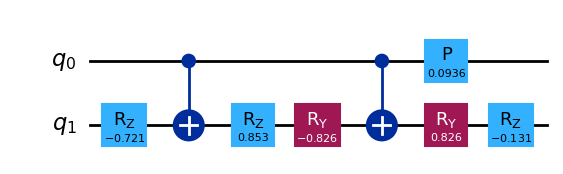

In [2]:
def zyz_decompose(U, eps=1e-12):
    
    alpha = np.angle(np.linalg.det(U)) / 2.0
    W = U * np.exp(-1j*alpha)

    W00, W01 = W[0,0], W[0,1]
    W10, W11 = W[1,0], W[1,1]

    c = np.clip(abs(W00), 0.0, 1.0)  # = cos(g/2)
    s = np.clip(abs(W01), 0.0, 1.0)  # = sin(g/2)
    gamma = 2*np.arctan2(s, c)

    def wrap(x): return (x + np.pi) % (2*np.pi) - np.pi

    if s < eps:
        gamma = 0.0
        beta  = wrap(np.angle(W11) - np.angle(W00))
        delta = 0.0
    elif c < eps:                     # gamma ~ π
        gamma = np.pi
        beta  = wrap(np.angle(W10) - np.angle(W01) + np.pi)  # choose δ=0
        delta = 0.0
    else:                              # generic case
        delta = wrap(np.angle(W01) - np.angle(W00) - np.pi)
        beta  = wrap(np.angle(W11) - np.angle(W01) + np.pi)

    alpha, beta, gamma, delta = map(wrap, (alpha, beta, gamma, delta))

    def Rz(t): 
        t2 = t/2
        return np.array([[np.exp(-1j*t2), 0],[0, np.exp(1j*t2)]], complex)
    
    def Ry(t):
        t2 = t/2; c,s = np.cos(t2), np.sin(t2)
        return np.array([[c, -s],[s, c]], complex)
    
    Urec = np.exp(1j*alpha) * (Rz(beta) @ Ry(gamma) @ Rz(delta))

    if np.allclose(-U, Urec, atol=1e-10):
        alpha = wrap(alpha + np.pi)

    return alpha, beta, gamma, delta

def controlled_U(U) -> QuantumCircuit:
    alpha, beta, gamma, delta = zyz_decompose(U)

    qc = QuantumCircuit(2)
    # C
    qc.rz((delta - beta)/2, 1)
    qc.cx(0, 1)
    # B
    qc.rz(-(delta + beta)/2, 1)
    qc.ry(-gamma/2, 1)
    qc.cx(0, 1)
    # A 
    qc.ry(gamma/2, 1)
    qc.rz(beta, 1)
    # P
    qc.p(alpha, 0)

    return qc

# Example usage for random unitary
U = random_unitary(2).data
qc = controlled_U(U)
display(qc.draw("mpl"))


## LDD Decomposition — Code Structure Overview

Below is the implementation of the LDD (linear-depth) construction for multi-controlled rotations and multi-controlled unitaries.

- `Rx(theta)` returns the numeric $R_x(\theta)$ matrix.
- `P(n)` applies the forward sequence of controlled $R_x$ rotations with angles $\pi/2^{k}$.
- `Q(n)` applies all lower-order multi-controlled rotations needed for the recursion.
- `multi_controlled_RX(n)` builds an $n$-controlled $R_x$ using the standard LDD pattern:
  apply $P(n)$ → controlled rotation → $Q(n)$ → undo everything.
- `P_U(n, U)` is the same pattern as `P(n)`, but generalized: each step replaces $U$ by its square root and applies a single-controlled version of it.
- `multi_controlled_U(n, U)` is the full recursive construction:
  apply $P_U(n, U)$ → controlled $U^{1/2^{n-1}}$ → $Q(n)$ → inverse uncomputation.

This matches the structure required by the algorithm in the paper and uses only single-controlled-$U$ gates plus inverses.

In [3]:
def Rx(theta):
    c = np.cos(theta/2)
    s = np.sin(theta/2)
    return np.array([
        [c, -1j*s],
        [-1j*s, c]
    ], dtype=complex)

def P(n: int) -> QuantumCircuit:
    qc = QuantumCircuit(n + 1, name="P")
    for k in reversed(range(2, n + 1)):
        Rx_matrix = Rx(pi / (2**(n - k + 1)))
        qc.append(controlled_U(Rx_matrix), [k - 1, n])

    return qc

def Q(n: int) -> QuantumCircuit:
    qc = QuantumCircuit(n + 1, name="Q")
    for k in reversed(range(1, n)):
        qc.append(multi_controlled_RX(k), range(k + 1))
    
    return qc

def multi_controlled_RX(n: int) -> QuantumCircuit:
    qc = QuantumCircuit(n + 1, name="LDD mcRX")
    qc.append(P(n), range(n + 1))
    Rx_matrix = Rx(pi / (2**(n - 1)))
    qc.append(controlled_U(Rx_matrix), [0, n])
    qc.append(Q(n), range(n + 1))
    qc.append(P(n).inverse(), range(n + 1))
    qc.append(Q(n).inverse(), range(n + 1))

    return qc

def P_U(n: int, U) -> QuantumCircuit:
    qc = QuantumCircuit(n + 1, name="P_U")
    for k in reversed(range(2, n + 1)):
        U = sqrtm(U)
        cu_gate = multi_controlled_U(1, U)
        qc.append(cu_gate, [k - 1, n])

    return qc

def multi_controlled_U(n: int, U) -> QuantumCircuit:
    qc = QuantumCircuit(n + 1, name="LDD mcu")
    qc.append(P_U(n, U), range(n + 1))
    root_U = fractional_matrix_power(U, 2**(-n + 1))
    qc.append(controlled_U(root_U), [0, n])
    qc.append(Q(n), range(n + 1))
    qc.append(P_U(n, U).inverse(), range(n + 1))
    qc.append(Q(n).inverse(), range(n + 1))

    return qc

## Correctness Testing

To verify that the recursive LDD construction matches Qiskit's built-in multi-controlled unitary, I use a direct matrix-comparison test.

- `test_mcu(n, U)`  
  builds the LDD version of an $n$-controlled-$U$ gate, and compares its full unitary matrix to Qiskit's `UnitaryGate(U).control(n)`.

- `run_test_mcu(n_max, m_max)`  
  generates random $2\times2$ unitaries and checks all values of $n$ from 1 to `n_max`, repeating this `m_max` times.

The test reports a ✅ when the matrices match within numerical tolerance (`1e-5`) and ❌ otherwise.


In [4]:
def test_mcu(n, U):
    mcu = multi_controlled_U(n, U)
    qc_mcu = QuantumCircuit(n + 1)
    qc_mcu.append(mcu, range(n + 1))
    matrix_mcu = Operator(qc_mcu).data
    
    qc_ref_mcu = QuantumCircuit(n + 1)
    qc_ref_mcu.append(UnitaryGate(U).control(n), range(n + 1))
    matrix_ref_mcu = Operator(qc_ref_mcu).data

    return np.allclose(matrix_mcu, matrix_ref_mcu, 1e-5)

def run_test_mcu(n_max, m_max):
    for m in range(m_max):
        for n in range(1, n_max + 1):
            U = random_unitary(2).data
            if test_mcu(n, U):
                print(f"✅ Test passed: n_controls = {n}, on unitary number {m}")
            else:
                print(f"❌ Test failed: n_controls = {n}, on unitary number {m}")

run_test_mcu(4, 6)

✅ Test passed: n_controls = 1, on unitary number 0
✅ Test passed: n_controls = 2, on unitary number 0
✅ Test passed: n_controls = 3, on unitary number 0
✅ Test passed: n_controls = 4, on unitary number 0
✅ Test passed: n_controls = 1, on unitary number 1
✅ Test passed: n_controls = 2, on unitary number 1
✅ Test passed: n_controls = 3, on unitary number 1
✅ Test passed: n_controls = 4, on unitary number 1
✅ Test passed: n_controls = 1, on unitary number 2
✅ Test passed: n_controls = 2, on unitary number 2
✅ Test passed: n_controls = 3, on unitary number 2
✅ Test passed: n_controls = 4, on unitary number 2
✅ Test passed: n_controls = 1, on unitary number 3
✅ Test passed: n_controls = 2, on unitary number 3
✅ Test passed: n_controls = 3, on unitary number 3
✅ Test passed: n_controls = 4, on unitary number 3
✅ Test passed: n_controls = 1, on unitary number 4
✅ Test passed: n_controls = 2, on unitary number 4
✅ Test passed: n_controls = 3, on unitary number 4
✅ Test passed: n_controls = 4, 